In [120]:
!pip install langchain>=0.2.0, langchain-ollama>=0.1.0, pydantic>=2.0, typing-extensions>=4.9.0, langchain-community>=0.3.27, langgraph>=0.3.66, chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [121]:
!pip install -U jq


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [122]:
from sqlalchemy import (
    Column, Integer, String, ForeignKey, LargeBinary, Text, DateTime, func
)
from sqlalchemy.orm import declarative_base, relationship
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers.json import JsonOutputParser
from pydantic import BaseModel, Field 
from typing import List, Optional, Dict, Tuple, Any, Union, Set
import regex
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import torch
import subprocess
import os
from IPython.display import clear_output
import re
from collections import defaultdict
import json
from langchain_community.document_loaders import JSONLoader
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from typing import TypedDict, List, Dict, Optional, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
from langchain.schema import Document 
from langchain_core.messages import BaseMessage


In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# let's download and host/open ollama server on kaggle
!curl -fsSL https://ollama.com/install.sh | sh
subprocess.Popen("ollama serve", shell=True)
clear_output()

In [144]:
# now we need to download the model we want to use, here it is gemma3n latest
subprocess.Popen("ollama pull gemma3n", shell=True)

clear_output()


In [145]:
# Creating our model with Ollama
llm = ChatOllama(
    model="gemma3n",
    temperature=0.5,
)

[GIN] 2025/08/06 - 21:46:19 | 200 |     106.643µs |       127.0.0.1 | HEAD     "/"


time=2025-08-06T21:46:19.970Z level=INFO source=routes.go:1297 msg="server config" env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_CONTEXT_LENGTH:4096 OLLAMA_DEBUG:INFO OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NEW_ENGINE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:1 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://* vscode-file://*] OLLAMA_SCHED_SPREAD:false ROCR_VISIBLE_DEVICE

[GIN] 2025/08/06 - 21:46:20 | 200 |  324.970071ms |       127.0.0.1 | POST     "/api/pull"


# Functions that generate outputs with gemma3n

In [146]:
# Laguages to codes and codes to languages dictionaries
language_codes = {
    "English": "en",
    "Русский": "ru",
    "한국어": "ko",
    "中文": "zh",
    "日本語": "ja",
    "Español": "es",
    "Français": "fr",
    "Deutsch": "de",
    "Italiano": "it",
    "Português": "pt"
}
codes_language = {
    "en":"English",
    "ru":"Русский",
    "ko":"한국어",
    "zh":"中文",
    "ja":"日本語",
    "es":"Español",
    "fr":"Français",
    "de":"Deutsch",
    "it":"Italiano",
    "pt":"Português"
}

In [147]:
class TranslationResponse(BaseModel):
    translations: List[str] = Field(description="List of possible translations")

class DefinitionResponse(BaseModel):
    definitions: List[str] = Field(description="List of definitions in the target language")

class ExamplesResponse(BaseModel):
    examples: List[str] = Field(description="List of usage examples in the target language")

def generate_translation(text: str, src_language: str, tgt_language: str) -> dict:
    """
    Generate translations in a given text from the source language to the target language.

    Args:
        text (str): The input text containing one or more sentences to translate.
        src_language (str): The language of the original text (source language).
        tgt_language (str): The language into which the text will be translated (target language).

    Returns:
        dict: A dictionary containing:
            {{
                'word1': 
                {   
                    'translations': [''],
                },
                'word2': 
                {   
                    'translations': [''],
                }
            }}
 
    """
    # Create a translation prompt using PromptTemplate
    translation = PromptTemplate(
        input_variables=["text", "src_language", "tgt_language"],
        template=translation_prompt
    )

    # Format the prompt with provided variables
    prompt = translation.format(
        text=text,
        src_language=src_language,
        tgt_language=tgt_language,
    )

    # Use the LLM to generate the translation
    response = llm.invoke(prompt, config={"response_format": "json_object"})

    # Create parser instance with the response model
    parser = JsonOutputParser(pydantic_object=TranslationResponse)
    
    try:
        # Parse the response into the defined structure
        parsed_response = parser.parse(response.content)

    except Exception as e:
        parsed_response = {
            "original": text,
            "message": f"Error parsing response: {e}"
        }
        
    words_dict = {}
    for word, translation in parsed_response.items():
        words_dict[word] = {
            "translations": [translation]
        }


    return words_dict
    

        

def generate_definitions(word: str, language: str,  context: Optional[str]=None) -> dict:
    """
    Generate definitions for a given word in a specified language.
    
    Args:
        word (str): The word to define.
        language (str): The language in which definitions are to be provided.
        context (str): The original sentence or context in which the word is used.

    Returns:
        dict: A dictionary containing:
        {{
            "definition": "single definition",
        }}
    """
    # Create a definition prompt using PromptTemplate
    definition = PromptTemplate(
        input_variables=["word", "language", "context"],
        template=definition_prompt  # Changed from example_prompt to definition_prompt
    )
    
    # Format the prompt with the provided variables
    prompt = definition.format(
        language=language,
        word=word,
        context=context
    )
    
    # Use the llm to invoke the prompt and get the response
    response = llm.invoke(prompt, config={"response_format": "json_object"})

    # Create parser instance with the response model
    parser = JsonOutputParser(pydantic_object=DefinitionResponse)
    
    try:
        # Parse the response into the defined structure
        parsed_response = parser.parse(response.content)
        parsed_response['definition'] = [parsed_response['definition']]
        return parsed_response
    
    except Exception as e:
        return {
            "original": word,
            "message": f"Failed to parse response: {str(e)}"
        }

def generate_examples(word: str, language: str, definition: Optional[str] = None, examples_number: Optional[int] = 1) -> dict:
    """
    Generate examples of usage for a given type in a foreign language.
    Args:
        word(str)
        language (str): The language in which examples are to be provided.  
        definition (str): The definition of the word or phrase.
        examples_number (int): The number of examples to generate.
    Returns:
        dict: A dictionary containing:
        {
            "examples": ["example sentence 1", "example sentence 2", ...],
            "examples_number": {examples_number},
        }
    """
    # Create an example prompt using PromptTemplate
    example = PromptTemplate(
        input_variables=["word", "foreign_language", "definition", "examples_number"],
        template=example_prompt
    )
    # Format the prompt with the provided variables
    prompt = example.format(word=word, 
                            language=language, 
                            definition=definition, 
                            examples_number=examples_number)
    # Use the llm to invoke the prompt and get the response
    response = llm.invoke(prompt, config={"response_format": "json_object"})

    # Create parser instance with the response model
    parser = JsonOutputParser(pydantic_object=ExamplesResponse)
    
    try:
        # Parse the response into the defined structure
        parsed_response = parser.parse(response.content)
        return parsed_response
    
    except Exception as e:
        return {
            "original": word,
            "message": "Failed to parse response"
        }


# Prompts

In [148]:
translation_prompt = translation_prompt = """
You receive a text.

Task:
1. For each sentence, extract all **content words** only (exclude stopwords such as articles, prepositions, conjunctions, auxiliaries, pronouns, names).
2. Convert each extracted word to its **base dictionary form (lemma)** — for example: "told" → "tell", "running" → "run".
3. Translate each lemma from {src_language} to **{tgt_language}** (use the target language exactly as provided, not English by default).
4. Remove duplicates — only include unique lemmas for the whole input text.
5. Output as a JSON object in the format:
    {{
        'word1': 'translation',
        'word2': 'translation'
    }}
Only include unique words per input (no duplicates).
Do not add extra explanations or context.

Input text:
"{text}"

    """

definition_prompt = """
    Generate a single definition for the word "{word}" in {language}, based only on its meaning in the given sentence:

    Sentence:
    "{context}"

    Rules:
    1. Provide exactly one short, clear definition matching the word's meaning in this sentence.
    2. No other meanings, no examples.
    3. The definition must be in {language}.
    4. If unsure, mark as such and give your best guess.

    Return JSON only in the format:
    {{
        "definition": "single definition",
    }}
"""



example_prompt = """
    Generate {examples_number} simple sentences for "{word}" in {language} using only the given definition:

    Definition:
    "{definition}"

    Rules:
    1. Sentences must match this definition exactly; ignore other meanings.
    2. Grammar must be correct and natural.
    3. Use simple, clear vocabulary for learners.
    4. Avoid repeating the same structure or idea.
    5. "message" field is only for missing/uncertain examples or rare meanings.

    Output JSON only:

    {{
        "examples": ["example sentence 1", ...],
    }}

    """


In [150]:
def save_dict_to_json(
    dictionary: Dict[Union[str, Tuple[str, str]], Any],
    file_path: str = "dictionary.json"
) -> bool:
    """
    Save a dictionary to a JSON file.

    This function serializes the provided dictionary into JSON format and saves it to a file. 
    If the dictionary contains tuple keys, they will be automatically converted to strings 
    because JSON does not support tuple keys.

    Args:
        dictionary (Dict[Union[str, Tuple[str, str]], Any]):
            The dictionary to save. Keys can be strings or tuples of strings.
        file_path (str, optional):
            The path to the JSON file where the dictionary should be saved.
            Defaults to "translations.json".

    Returns:
        bool:
            True if the dictionary was saved successfully, False if an error occurred.

    Notes:
        - Uses UTF-8 encoding for proper Unicode support.
        - Sets `ensure_ascii=False` to preserve non-ASCII characters in readable form.
        - Uses `indent=4` for pretty printing.
    """
    try:
        # Convert tuple keys to strings to make JSON serializable
        serializable_dict = {
            str(k) if isinstance(k, tuple) else k: v
            for k, v in dictionary.items()
        }

        # Write dictionary to JSON file
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(serializable_dict, f, ensure_ascii=False, indent=4)

        return True

    except (TypeError, ValueError) as e:
        print(f"[ERROR] Failed to serialize dictionary to JSON: {e}")
        return False
    except OSError as e:
        print(f"[ERROR] Failed to write to file '{file_path}': {e}")
        return False

In [151]:
text_en = '''Yesterday, I went to the park with my friend. The sun was shining and the birds were singing.
We walked along the river and saw some ducks.
After that, we sat on a bench and ate ice cream.
It was a perfect day.
'''
text_ru = """Вчера я ходил в парк с другом. Солнце светило, а птицы пели.
Мы гуляли вдоль реки и видели уток.
Потом мы сели на скамейку и ели мороженое.
Это был прекрасный день."""
text_kr = """어제 저는 친구와 함께 공원에 갔어요. 해가 빛나고 새들이 노래했어요.
우리는 강을 따라 걸으면서 오리를 봤어요.
그 다음 벤치에 앉아서 아이스크림을 먹었어요.
정말 완벽한 하루였어요."""
text_jp = """昨日、私は友達と一緒に公園へ行きました。太陽が輝き、鳥が歌っていました。
川沿いを歩きながら、カモを見ました。
そのあと、ベンチに座ってアイスクリームを食べました。
とても素敵な一日でした。"""
text_sp = """Ayer fui al parque con mi amigo. El sol brillaba y los pájaros cantaban.
Caminamos junto al río y vimos algunos patos.
Después nos sentamos en un banco y comimos helado.
Fue un día perfecto."""
text_fr = """Hier, je suis allé au parc avec mon ami. Le soleil brillait et les oiseaux chantaient.
Nous avons marché le long de la rivière et vu des canards.
Ensuite, nous nous sommes assis sur un banc et avons mangé une glace.
C’était une journée parfaite."""

# Rag

In [152]:
!mkdir retriever

mkdir: cannot create directory ‘retriever’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [153]:
#loading our dictionary
file_path = "/kaggle/working/dictionary.json"

if os.path.exists(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            dictionary_data = json.load(f)
        print(f"[INFO] Dictionary loaded: {len(dictionary_data)} words.")
    except json.JSONDecodeError:
        print(f"[ERROR] File {file_path} is corrupted or not valid JSON.")
        dictionary_data = {}
else:
    print(f"[WARNING] File {file_path} not found. Using an empty dictionary.")
    dictionary_data = {}
    
docs = [Document(page_content=word) for word in dictionary_data.keys()]

embeddings = HuggingFaceEmbeddings(model_name =  "all-MiniLM-L6-v2")
db  = Chroma.from_documents(docs , embeddings , persist_directory='/kaggle/working/retriever')
retriever = db.as_retriever()

[INFO] Dictionary loaded: 37 words.


In [154]:
def get_similar_words_rag(word: str, text: str, k: int = 5) -> List[str]:
    """
    Retrieve a list of words similar to the given input word using a RAG (Retrieval-Augmented Generation) retriever.

    This function queries a retriever object for documents related to the given `word` 
    and then extracts similar words from the retrieved content. The retrieved documents 
    are processed as either JSON (from which keys are extracted) or plain text.

    Args:
        word (str):
            The input word to search for.
        text (str):
            The reference text or corpus to be searched against.
            (Currently unused in this implementation.)
        k (int, optional):
            The maximum number of retrieved results to process.
            Defaults to 5.

    Returns:
        List[str]:
            A list of similar words found in the retrieved documents.
            Returns an empty list if retrieval fails or no valid data is found.

    Notes:
        - Requires a global `retriever` object with an `.invoke()` method 
          that returns either a list of documents or a single document.
        - Each document must have a `.page_content` attribute.
        - If `.page_content` is JSON, the keys are extracted as similar words.
          If it's plain text, the content itself is added to the result.
        - All retrieval and parsing errors are caught and logged to console.

    Example:
        >>> get_similar_words_rag("apple", "", k=3)
        ['fruit', 'macintosh', 'granny smith']
    """
    try:
        # Query retriever for documents related to the input word
        results = retriever.invoke(word)

        # Ensure results is always a list for consistent iteration
        if not isinstance(results, list):
            results = [results]

        similar_words = []

        # Process up to k retrieved documents
        for doc in results[:k]:
            try:
                # Try to parse content as JSON and extract dictionary keys
                data = json.loads(doc.page_content)
                similar_words.extend(data.keys())
            except json.JSONDecodeError:
                # If parsing fails, treat content as plain text
                similar_words.append(doc.page_content)

        return similar_words

    except Exception as e:
        # Log the retrieval failure
        print(f"[DEBUG] RAG search failed for '{word}': {e}")
        return []


In [155]:
class State(TypedDict):
    text: str  
    src_language: str
    tgt_language: str
    words: Set[str] 
    translations: Dict[str, List[str]] 
    definitions: Dict[str, List[str]]  
    examples: Dict[str, List[str]] 
    examples_number: Dict[str, int]
    similar_words: Dict[str, List[str]]  
    saved_to_json: bool

In [156]:
initial_state = {
        'text':text_en, 
        'src_language':'en',
        'tgt_language':'ko',
        'words':set(),
        "translations": {'park': []},
        "definitions": {'park': []},
        "examples": {'park': []},
        "examples_number": {'park': 1},
        "similar_words": {'park': []},
        "saved_to_json":False
}

# Node functions

In [157]:
def save_dict_to_json(
    dictionary: Dict[Union[str, Tuple[str, str]], Any],
    file_path: str = "dictionary.json"
) -> bool:
    """
    Save a dictionary to a JSON file.

    This function serializes the provided dictionary into JSON format and saves it to a file. 
    If the dictionary contains tuple keys, they will be automatically converted to strings 
    because JSON does not support tuple keys.

    Args:
        dictionary (Dict[Union[str, Tuple[str, str]], Any]):
            The dictionary to save. Keys can be strings or tuples of strings.
        file_path (str, optional):
            The path to the JSON file where the dictionary should be saved.
            Defaults to "translations.json".

    Returns:
        bool:
            True if the dictionary was saved successfully, False if an error occurred.

    Notes:
        - Uses UTF-8 encoding for proper Unicode support.
        - Sets `ensure_ascii=False` to preserve non-ASCII characters in readable form.
        - Uses `indent=4` for pretty printing.
    """
    try:
        # Convert tuple keys to strings to make JSON serializable
        serializable_dict = {
            str(k) if isinstance(k, tuple) else k: v
            for k, v in dictionary.items()
        }

        # Write dictionary to JSON file
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(serializable_dict, f, ensure_ascii=False, indent=4)

        return True

    except (TypeError, ValueError) as e:
        print(f"[ERROR] Failed to serialize dictionary to JSON: {e}")
        return False
    except OSError as e:
        print(f"[ERROR] Failed to write to file '{file_path}': {e}")
        return False

In [180]:


def translate_words_node(state: "State") -> dict:
    """
    Node: Translate words from source language to target language.

    This function:
    1. Calls `generate_translation()` to translate the input text.
    2. Extracts the set of words from the translation keys.
    3. Returns updated `words` and `translations` in the state.

    Args:
        state (State): Current state containing `text`, `src_language`, and `tgt_language`.

    Returns:
        dict: Updated state keys:
            - 'words': set of unique words found in translation
            - 'translations': dict with translations
    """
    translations = generate_translation(
        text=state["text"],
        src_language=codes_language[state['src_language']],  # Convert to language code
        tgt_language=codes_language[state['tgt_language']]
    )

    # Extract words from translation keys
    words = set(translations.keys())

    return {
        'words': words,
        'translations': translations
    }


def generate_definitions_node(state: "State") -> dict:
    """
    Node: Generate definitions for translated words.

    This function:
    1. Iterates over existing words in `definitions`.
    2. Calls `generate_definitions()` for each word.
    3. Extends the definitions list if new ones are found.

    Args:
        state (State): Current state containing `definitions` and `src_language`.

    Returns:
        dict: Updated 'definitions' key in state.
    """
    definitions = state['definitions']

    for word in list(definitions.keys()):  # Copy keys to avoid runtime mutation issues
        def_dict = generate_definitions(
            word,
            codes_language[state['src_language']]
        )

        # Append new definitions if they exist
        if def_dict.get('definition'):
            definitions[word].extend(def_dict['definition'])

    return {'definitions': definitions}


def generate_examples_node(state: "State") -> dict:
    """
    Node: Generate example sentences for each word.

    This function:
    1. Uses `examples_number` to determine how many examples per word.
    2. Calls `generate_examples()` for each word.
    3. Extends the examples list if new ones are found.

    Args:
        state (State): Current state containing `examples`, `examples_number`, `definitions`.

    Returns:
        dict: Updated 'examples' key in state.
    """
    examples = state['examples']

    for word in examples.keys():

        ex_number = 1


        if state['examples_number'].get(word):
            ex_number = state['examples_number'][word]

        ex_dict = generate_examples(
            word,
            codes_language[state['src_language']],
            state['definitions'][word],
            ex_number
        )

        # Append examples if found
        if ex_dict.get('examples'):
            examples[word].extend(ex_dict['examples'])

    return {
        'examples': examples
    }


def generate_similar_node(state: "State") -> dict:
    """
    Node: Find semantically similar words for each word using RAG.

    This function:
    1. Iterates through `similar_words` keys.
    2. Calls `get_similar_words_rag()` to retrieve similar words from the retriever.
    3. Updates the list of similar words.

    Args:
        state (State): Current state containing `similar_words` and `text`.

    Returns:
        dict: Updated 'similar_words' key in state.
    """
    similar_words = state['similar_words']

    for word in similar_words.keys():
        synonyms = get_similar_words_rag(word, state['text'])
        similar_words[word] = synonyms

    return {'similar_words': similar_words}


def save_to_json_node(state: "State") -> dict:
    """
    Node: Save merged dictionary data to JSON.

    This function:
    1. Merges words, translations, definitions, and examples into a final dict.
    2. Saves it to JSON using `save_to_json()`.
    3. Stores 'final_dict' and 'saved_to_json' in the state.

    Args:
        state (State): Current state with 'words', 'translations', 'definitions', 'examples'.

    Returns:
        dict: Updated state keys:
            - 'final_dict': full merged dictionary
            - 'saved_to_json': result of saving operation (bool)
    """
    merged = {}

    for word in state["words"]:
        merged[word] = {
            "translations": state["translations"].get(word, []),
            "definitions": state["definitions"].get(word, []),
            "examples": state["examples"].get(word, [])
        }
    final_merged = {(state['src_language'], state['tgt_language']) : merged}
    # Save merged dictionary
    saved = save_dict_to_json(final_merged)

    return {
        'final_dict': final_merged,
        'saved_to_json': saved
    }


# Building Graph

In [181]:
graph = StateGraph(State)

graph.add_node("translate_words", translate_words_node)
graph.add_node("generate_definitions", generate_definitions_node)
graph.add_node("generate_examples", generate_examples_node)
graph.add_node("generate_similar", generate_similar_node)
graph.add_node("save_to_json", save_to_json_node)

graph.add_edge(START, "translate_words")
graph.add_edge("translate_words", "generate_definitions")
graph.add_edge("generate_definitions", "generate_examples")
graph.add_edge("generate_examples", "generate_similar")
graph.add_edge("generate_similar", "save_to_json")
graph.add_edge("save_to_json", END)

compiled_graph = graph.compile()

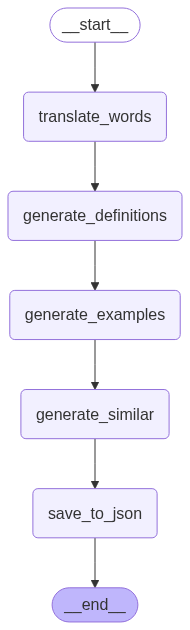

In [182]:
from IPython.display import Image , display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [183]:
test_state = {
        'text':text_en, 
        'src_language':'en',
        'tgt_language':'ko',
        'words':set(text_en.split()),
        "translations": {'park': []},
        "definitions": {'park': []},
        "examples": {'park': []},
        "examples_number": {'park': 1},
        "similar_words": {'park': []},
        "saved_to_json":False
}

In [184]:
result = compiled_graph.invoke(test_state)

time=2025-08-06T22:38:17.861Z level=INFO source=server.go:135 msg="system memory" total="31.4 GiB" free="28.9 GiB" free_swap="0 B"
time=2025-08-06T22:38:17.863Z level=INFO source=server.go:175 msg=offload library=cpu layers.requested=-1 layers.model=36 layers.offload=0 layers.split="" memory.available="[28.9 GiB]" memory.gpu_overhead="0 B" memory.required.full="5.0 GiB" memory.required.partial="0 B" memory.required.kv="280.0 MiB" memory.required.allocations="[5.0 GiB]" memory.weights.total="2.6 GiB" memory.weights.repeating="2.2 GiB" memory.weights.nonrepeating="420.4 MiB" memory.graph.full="2.0 GiB" memory.graph.partial="3.7 GiB"
time=2025-08-06T22:38:17.995Z level=INFO source=server.go:438 msg="starting llama server" cmd="/usr/local/bin/ollama runner --ollama-engine --model /root/.ollama/models/blobs/sha256-38e8dcc30df4eb0e29eaf5c74ba6ce3f2cd66badad50768fc14362acfb8b8cb6 --ctx-size 4096 --batch-size 512 --threads 2 --no-mmap --parallel 1 --port 35879"
time=2025-08-06T22:38:17.995Z le

[GIN] 2025/08/06 - 22:41:28 | 200 |         3m11s |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/08/06 - 22:41:59 | 200 | 30.758359308s |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/08/06 - 22:42:41 | 200 | 42.452776657s |       127.0.0.1 | POST     "/api/chat"
